# Sentiment Analysis Project 
## Tim Dentry


1. Data sourcing and sentiment analysis.

have to analyse product reviews after some text preprocessing steps and then build an ML model to get the sentiments corresponding to the users' reviews and ratings for movies

STEPS TO BE PERFORMED:

A. Exploratory data analysis

* In the test data, there appear to be reviews for books and movies interspersed.  Moreso, the usage of the word "book" within movie reviews can be problematic
* Also found URLs and very odd alphanumeric sequences that don't map to anything within the body of the user rating text (test data):  

\"__\&#x200B;"

https://preview.redd.it/idd26dmciyl51.jpg?width=1280&format=pjpg&auto=webp&s=ff839d798b9e2824fd47af9602e4beb7273135a7__

\"\[ Movie Spoiler\]"

B. Data cleaning


* Need to remove extraneous and not useful sequences of "..."

* I also found occasional line break sequences, represented as "br" with brackets - this needs to be removed:  \<br /><br />

C. Text preprocessing


In order to extract features from the text data, we are going to try several methods,  including bag-of-words, TF-IDF vectorization or word embedding.

The goal is to a solid performing prediction model, using a binary classifier employing Logistic Regression.  





## 1. Data sourcing and sentiment analysis.

In [189]:
# Importing necessary basic python data and file manipulation packages
import os,glob
import pandas as pd
# used to read the files in as dataframes for manipulation
pd.options.display.float_format = "{:,.5f}".format
# shows up to 5 decimal places
import swifter
#speed things up with pandas using swifter for dataframes and nonvectorized functions
import numpy as np 
# mathematical calculations
import csv
# will be used to export results as csv files
from collections import Counter
# takes input in a variety of data types and creates dictionary type objects (count of iterable elements)
import pickle as cPickle
# just in case we want to export our model

# Important sklearn tools
from sklearn.feature_extraction.text import TfidfVectorizer
# this will be used to convert raw text to a matrix of TF-IDF features
from sklearn.feature_selection import chi2
# might use this for weeding out the features that are most likely to be independent of class
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
# allows for automation in the workflows for the data transforms
from sklearn.model_selection import train_test_split
# splits our training data into a n/m ratio in order to train our model
from sklearn.linear_model import LogisticRegression
# our standard classifier
from sklearn.naive_bayes import MultinomialNB
# not sure if I am going to use this yet
from sklearn.metrics import confusion_matrix
# confusion matrix is used to evaluate the accuracy of a classification
from sklearn.metrics import accuracy_score, classification_report
# another scoring method, not sure if I'm going to finish with this

# Data prep - the NLTK tool set that will allow us to stem, lemmatizie and tokenize
from nltk.corpus import stopwords
# remove words with no relevancy 
from nltk.stem import WordNetLemmatizer
# stem and lemm, the two twins of goodness for NLP folks
from nltk.tokenize import word_tokenize
from nltk import FreqDist
# tokenizing function inherent to NLTK
import re # just in case we need to apply regex where the above imports do not work as well

# import a library to help with the imbalance of data in class 0
import imblearn
from imblearn import  over_sampling
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler 

# some graphical display tools that we will use
from wordcloud import WordCloud
import matplotlib.pyplot as plt, seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings('ignore')
import pickle as cPickle


In [190]:
# establish the file path for the files to use
training_data = "train.csv"
test_data = "test.csv"

In [191]:
# reading the dataset and assinging the 'train variable as the dataframe
# pd.options.display.max_colwidth = 120
train = pd.read_csv('train.csv')
test = pd.read_csv ('test.csv')

# Preliminary data analysis and understanding

In [192]:
# Confirming our knowledge of the data set after visual examination shows column headers:
    # ID, TEXT and LABEL 
train.columns

Index(['ID', 'TEXT', 'LABEL'], dtype='object')

In [193]:
# Let's get more info about the overall data set - this will tell us:
    # the number of entries, the data type of entries and how many total rows 
    # an interesting factor below is the memory usage - I am going to try and be cognizant of that
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70187 entries, 0 to 70186
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      70187 non-null  int64 
 1   TEXT    70180 non-null  object
 2   LABEL   70187 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.6+ MB


In [194]:
train['LABEL'].value_counts()
# can also be expressed as train.LABEL.value_counts()
# this shows that the number of book reviews is nearly double that of the positive and negative
    # movie reviews

0    35000
1    17645
2    17542
Name: LABEL, dtype: int64

In [195]:
train.head() # this shows the first 5 entries in the data set.  

,ID,TEXT,LABEL
0,7766,Wonderful summary of Sai's words on nature. It...,0
1,4631,"I'm not going to lie, I have a tough time liki...",0
2,67707,This is an excellent book. It has allowed me ...,0
3,93531,Reading the series one book at a time; fell in...,0
4,58527,Oh my gosh! So amazing! I love this book so mu...,0


In [196]:
train.tail() # shows the bottom 5 which shows the negative class

,ID,TEXT,LABEL
70182,1044,This was on TV last night. I painfully forced ...,2
70183,52365,". . . and never, ever see it. Now, I've been w...",2
70184,31078,"This is complete and absolute garbage, a fine ...",2
70185,32404,I am a Catholic taught in parochial elementary...,2
70186,50937,"Dumb is as dumb does, in this thoroughly unint...",2


In [197]:
# lets be sure to validate our "positive classification"
pos_sample = train.groupby('LABEL').head()
pos_sample # shows the embedded positive samples starting around row 35000

,ID,TEXT,LABEL
0,7766,Wonderful summary of Sai's words on nature. It...,0
1,4631,"I'm not going to lie, I have a tough time liki...",0
2,67707,This is an excellent book. It has allowed me ...,0
3,93531,Reading the series one book at a time; fell in...,0
4,58527,Oh my gosh! So amazing! I love this book so mu...,0
35000,18920,"Contrary to popular belief, this title , to me...",1
35001,77136,"I must admit, at first I was worried about Far...",1
35002,62544,What a great movie!! It's a touching story abo...,1
35003,81176,"I have seen this movie, just once, and I'm loo...",1
35004,62171,I just saw this movie for the first time last ...,1


# Let's examine the dataframes in a little more detail, focusing on any anomalies in the data

In [198]:
train.isnull().sum() # determining which elements have null fields ('TEXT') 
# this shows that seven text cells have 0 data (no text) - but what to do?  

ID       0
TEXT     7
LABEL    0
dtype: int64

In [199]:
type (train.TEXT)

pandas.core.series.Series

In [200]:
train[pd.isnull(train.TEXT)]

,ID,TEXT,LABEL
496,20259,NaN,0
1113,51042,NaN,0
11091,97977,NaN,0
11739,4250,NaN,0
13871,88145,NaN,0
16291,82338,NaN,0
21482,89583,NaN,0


In [201]:
round(100 * train.isnull().sum()/len(train.index),2) # this shows that less than 0.01% of rows have 
# null values


ID      0.00000
TEXT    0.01000
LABEL   0.00000
dtype: float64

In [202]:
# What we see above is that there are seven rows that have a "NaN value", and they are all
# -in the book section.  What to do?  # but can the existence of null values be a problem?  It certainly will be when running the tokenizer
# - against a pandas DF.  So let's replace the NaN values with an empty string

In [203]:
train.fillna('',inplace=True) # replacing the current NaN value with empty string in place

In [204]:
train[pd.isnull(train.TEXT)] #validating that there is no NaN

,ID,TEXT,LABEL


In [205]:
# let's evaluate our test data with the same methods to see if there might be a consideration
test.isnull().sum()


ID      0
TEXT    5
dtype: int64

In [206]:
round(100 * test.isnull().sum()/len(test.index),2)

ID     0.00000
TEXT   0.02000
dtype: float64

In [207]:
test[pd.isnull(test.TEXT)]

,ID,TEXT
5660,78201,NaN
9071,34530,NaN
10333,95106,NaN
13385,30728,NaN
14494,89930,NaN


In [208]:
# so in the above test example, we also see null fields - we must account for them in the same way

In [209]:
test.fillna('',inplace=True) # replacing the current NaN value with empty string in place

In [210]:
train[pd.isnull(train.TEXT)] #validating that there is no NaN

,ID,TEXT,LABEL


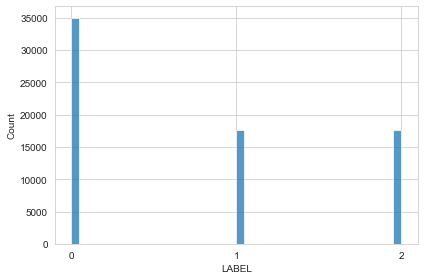

In [211]:
# Lets visually calculate the data
sns.histplot(data=train, x="LABEL")
plt.locator_params(axis="both", integer = True, tight = True)

plt.tight_layout()

In [212]:
# Above, we definitely see a class imbalance
# now we have two considerations:
# 1. potential to have to oversample?? SMOTE, perhaps? 
# 2. how to deal with null values


In [213]:
# train.nunique(axis=0)
train.TEXT.nunique()
# interesting that this analysis shows that there are only 68861 unique values in the text field
# yet, there are 70187 unique IDs.  Could there be the same reviews?  The is_null value amounts
# do not match up to the difference

68862

## explore the test set a bit more

In [214]:
test.columns # we shall see here that there are only two columns, no data labeling

Index(['ID', 'TEXT'], dtype='object')

In [215]:
test.head()

,ID,TEXT
0,18742,Great Book
1,14108,"In Yeager, Scott Bell has created a dynamic ch..."
2,52871,THEY DIED
3,39785,After looking at all the reviews I decided to ...
4,46174,I could not put this book down. This is a stor...


In [216]:
test.tail()

,ID,TEXT
30073,86744,What the heck was this. Somebody obviously rea...
30074,27493,i can't believe that NONE of the official revi...
30075,72221,"As a physicist, talk about blackholes and cosm..."
30076,16355,My giving this a score of 3 is NOT what I woul...
30077,83963,I attended one of the premieres last night and...


## Text pre processing
### use our data preparation pipeline to normalize text for processing

In [217]:
# Doing basic text cleaning - here is the function to clean the data
def clean_text(text):
    text = text.lower()
    pattern = re.compile('[\(\[].*?[\)\]]')
    text = re.sub(pattern, '', text)
    pattern = re.compile('[^\w\s]')
    text = re.sub(pattern, '', text)
    pattern = re.compile('[0-9]')
    text = re.sub(pattern, '', text)
    return text

In [218]:
train.TEXT[0:10] # let's see the first 10 lines of data before pre-processing

0    Wonderful summary of Sai's words on nature. It...
1    I'm not going to lie, I have a tough time liki...
2    This is an excellent book.  It has allowed me ...
3    Reading the series one book at a time; fell in...
4    Oh my gosh! So amazing! I love this book so mu...
5    This collection of diverse and beautiful poems...
6    If you are looking for an enjoyable series to ...
7                                        good pointers
8    Great read,belted along at breakneck speed,Hav...
9    Very interesting book about the new Pope.  Thi...
Name: TEXT, dtype: object

In [219]:
train.TEXT = train.TEXT.swifter.apply(clean_text)

Pandas Apply:   0%|          | 0/70187 [00:00<?, ?it/s]

In [220]:
# Let's make sure the data normalization worked

In [221]:
train.TEXT[0:10]

0    wonderful summary of sais words on nature it i...
1    im not going to lie i have a tough time liking...
2    this is an excellent book  it has allowed me t...
3    reading the series one book at a time fell in ...
4    oh my gosh so amazing i love this book so much...
5    this collection of diverse and beautiful poems...
6    if you are looking for an enjoyable series to ...
7                                        good pointers
8    great readbelted along at breakneck speedhavin...
9    very interesting book about the new pope  this...
Name: TEXT, dtype: object

In [222]:
# We are going to need to do the same to the test data (case flip, regex, etc)
# test.TEXT[0:10]

In [223]:
#test.TEXT = test.TEXT.swifter.apply(clean_text)

In [224]:
#test.TEXT[0:10] # it appears this text treatment worked.  

In [225]:
# nltk.download('stopwords')
# nltk.download('omw-1.4')
# nltk.download('punkt')
# nltk.download('wordnet')
sw = stopwords.words('english')
lem = WordNetLemmatizer()
# Function to tokenize and lemmatize reviews
def token_process(text):
    tokens = word_tokenize(text)
    tokens = list(filter(lambda x:x not in sw , tokens))
    tokens = [lem.lemmatize(w) for w in tokens]
    processed_text = ' '.join(tokens)
    return processed_text

train.TEXT = train.TEXT.swifter.apply(token_process)

Pandas Apply:   0%|          | 0/70187 [00:00<?, ?it/s]

In [226]:
train.TEXT[0:10] # let's compare now after stem/lemm
# this was the first line before:  wonderful summary of sais words on nature it i..
# we do see that stopwords are gone - but it does not seem that stemming occured

0    wonderful summary sais word nature pleasure re...
1    im going lie tough time liking people probably...
2    excellent book allowed view life way make reth...
3    reading series one book time fell love author ...
4    oh gosh amazing love book much anna amy everyt...
5    collection diverse beautiful poem brought tear...
6    looking enjoyable series readone touch heart g...
7                                         good pointer
8    great readbelted along breakneck speedhaving m...
9    interesting book new pope pontiff sport film b...
Name: TEXT, dtype: object

## Secondary analysis of data after preprocessing and cleaning

In [228]:
# Lets find some positive and negative words based on user sentiment
POS_WORDS = train[train.LABEL==1].TEXT.str.split().tolist()
POS_WORDS = [w for seq in POS_WORDS for w in seq]

NEG_WORDS = train[train.LABEL==2].TEXT.str.split().tolist()
NEG_WORDS = [w for seq in NEG_WORDS for w in seq]

In [229]:
len(POS_WORDS),len(NEG_WORDS)

(2086072, 2029038)

In [236]:
# frequency distribution of Positive words
positive = FreqDist(POS_WORDS).most_common(10)
print (positive)

[('br', 40061), ('film', 33224), ('movie', 30250), ('one', 18566), ('like', 11929), ('time', 10325), ('good', 9827), ('story', 9523), ('character', 9512), ('great', 8821)]


In [237]:
# frequency distribution of Negative words
negative = FreqDist(NEG_WORDS).most_common(10)
print (negative)

[('br', 42221), ('movie', 38479), ('film', 28553), ('one', 17421), ('like', 14996), ('even', 10000), ('good', 9654), ('time', 9640), ('character', 9593), ('bad', 9571)]


In [238]:
POS_DIST = pd.DataFrame(FreqDist(POS_WORDS).items(),columns =['word','WordCountPos'])
POS_DIST = POS_DIST.set_index('word')

NEG_DIST = pd.DataFrame(FreqDist(NEG_WORDS).items(),columns =['word','WordCountNeg'])
NEG_DIST = NEG_DIST.set_index('word')

In [239]:
COM_DIST = POS_DIST.join(NEG_DIST).fillna(0.1)
COM_DIST = COM_DIST[(COM_DIST.WordCountPos + COM_DIST.WordCountNeg)>50]
COM_DIST['score'] = np.log(COM_DIST.WordCountPos / COM_DIST.WordCountNeg)

In [240]:
COM_DIST.sort_values(by='score',ascending=True).head(10)

,WordCountPos,WordCountNeg,score
word,,,
boll,1,139.00000,-4.93447
uwe,1,100.00000,-4.60517
mstk,6,184.00000,-3.42318
zoey,2,58.00000,-3.36730
beowulf,2,58.00000,-3.36730
yawn,2,55.00000,-3.31419
steaming,2,54.00000,-3.29584
thunderbird,3,55.00000,-2.90872
crapbr,4,73.00000,-2.90417


In [241]:
COM_DIST.sort_values(by='score',ascending=True).tail(10)

,WordCountPos,WordCountNeg,score
word,,,
custer,134,6.00000,3.10608
eisenstein,93,4.00000,3.14631
christy,65,2.00000,3.48124
din,59,1.00000,4.07754
gundam,59,1.00000,4.07754
antwone,61,1.00000,4.11087
amir,92,1.00000,4.52179
prot,54,0.10000,6.29157
fido,54,0.10000,6.29157


## TF IDF vectorizer

In [242]:
X = train.TEXT.values
y = train.LABEL.values

In [243]:

td = TfidfVectorizer(
    max_features=20000,
    strip_accents='unicode',    # Remove accents and perform other character normalization during the preprocessing step. 
    analyzer='word',            # Whether the feature should be made of word or character n-grams.
    token_pattern=r'\w{1,}',    # Regular expression denoting what constitutes a “token”, only used if analyzer == 'word'
    ngram_range=(1, 3),         # The lower and upper boundary of the range of n-values for different n-grams to be extracted
    stop_words='english',
    sublinear_tf=True
)

X = td.fit_transform(X).toarray()


In [251]:
# Saving the vectorizer as a pickle file
with open('pickle/td.pkl', 'wb') as fin:
    pickle.dump(td, fin)

FileNotFoundError: [Errno 2] No such file or directory: 'pickle/td.pkl'

In [244]:
feature_names = td.get_feature_names()
print(feature_names[:20])
unigrams = [v for v in feature_names if len(v.split()) ==1]
bigrams = [v for v in feature_names if len(v.split()) ==2]
trigrams = [v for v in feature_names if len(v.split()) ==3]

['aa', 'aaron', 'ab', 'abandon', 'abandoned', 'abandonment', 'abbey', 'abbott', 'abby', 'abc', 'abducted', 'abduction', 'ability', 'ability make', 'able', 'able make', 'able read', 'able understand', 'able watch', 'ably']


In [245]:
unigrams[:10]

['aa',
 'aaron',
 'ab',
 'abandon',
 'abandoned',
 'abandonment',
 'abbey',
 'abbott',
 'abby',
 'abc']

In [246]:
bigrams[:10]

['ability make',
 'able make',
 'able read',
 'able understand',
 'able watch',
 'aboutbr br',
 'abr br',
 'abraham lincoln',
 'absolute favorite',
 'absolute worst']

In [247]:
trigrams[:10]

['absolutely loved book',
 'acting editing sound',
 'actually pretty good',
 'author great job',
 'avoid like plague',
 'bad acting bad',
 'bad bad bad',
 'bad br br',
 'bad special effect',
 'based true story']

In [248]:
X.shape, y.shape

((70187, 20000), (70187,))

In [187]:
# Train test split (this makes a 70/30 split of the training data)
X_train,X_dev,y_train,y_dev = train_test_split(X,y,test_size=0.2,random_state=50)

In [188]:
# Logistic Regression
logit = LogisticRegression()
logit.fit(X_train,y_train)

y_pred_train= logit.predict(X_train)

print('Training Accuracies')
clf_report_lr_train = classification_report(y_train,y_pred_train)
print(F'ACC : {accuracy_score(y_train,y_pred_train)}')
print(clf_report_lr_train)

y_pred_test= logit.predict(X_dev)
print('Test Accuracies')
clf_report_lr_test = classification_report(y_dev,y_pred_test)
print(F'ACC : {accuracy_score(y_test,y_pred_test)}')
print(clf_report_lr_test)

Training Accuracies
ACC : 0.9659833656877237
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     27889
           1       0.94      0.94      0.94     14180
           2       0.95      0.93      0.94     14080

    accuracy                           0.97     56149
   macro avg       0.96      0.96      0.96     56149
weighted avg       0.97      0.97      0.97     56149

Test Accuracies
ACC : 0.935389656646246
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      7111
           1       0.88      0.89      0.88      3465
           2       0.90      0.87      0.89      3462

    accuracy                           0.94     14038
   macro avg       0.92      0.92      0.92     14038
weighted avg       0.93      0.94      0.94     14038



# Observations from training the model and evaluating it with the dev (20%) data:  
    * We can see in the above results that the F1 score on the training data is high, and exceptionally high for class 0.  The F1 score for class 1 and 2 is lower, and that is most likely due to class imbalance.  My suspicion is that the model is overfitting in an effort to compensate for the (nearly) double amount of data in classes 1 and 2.  You can see then that in the Dev split, that the Dev accuracies are significantly lower for Class 1 and 2. 
    * We need to fix this imblance.  
  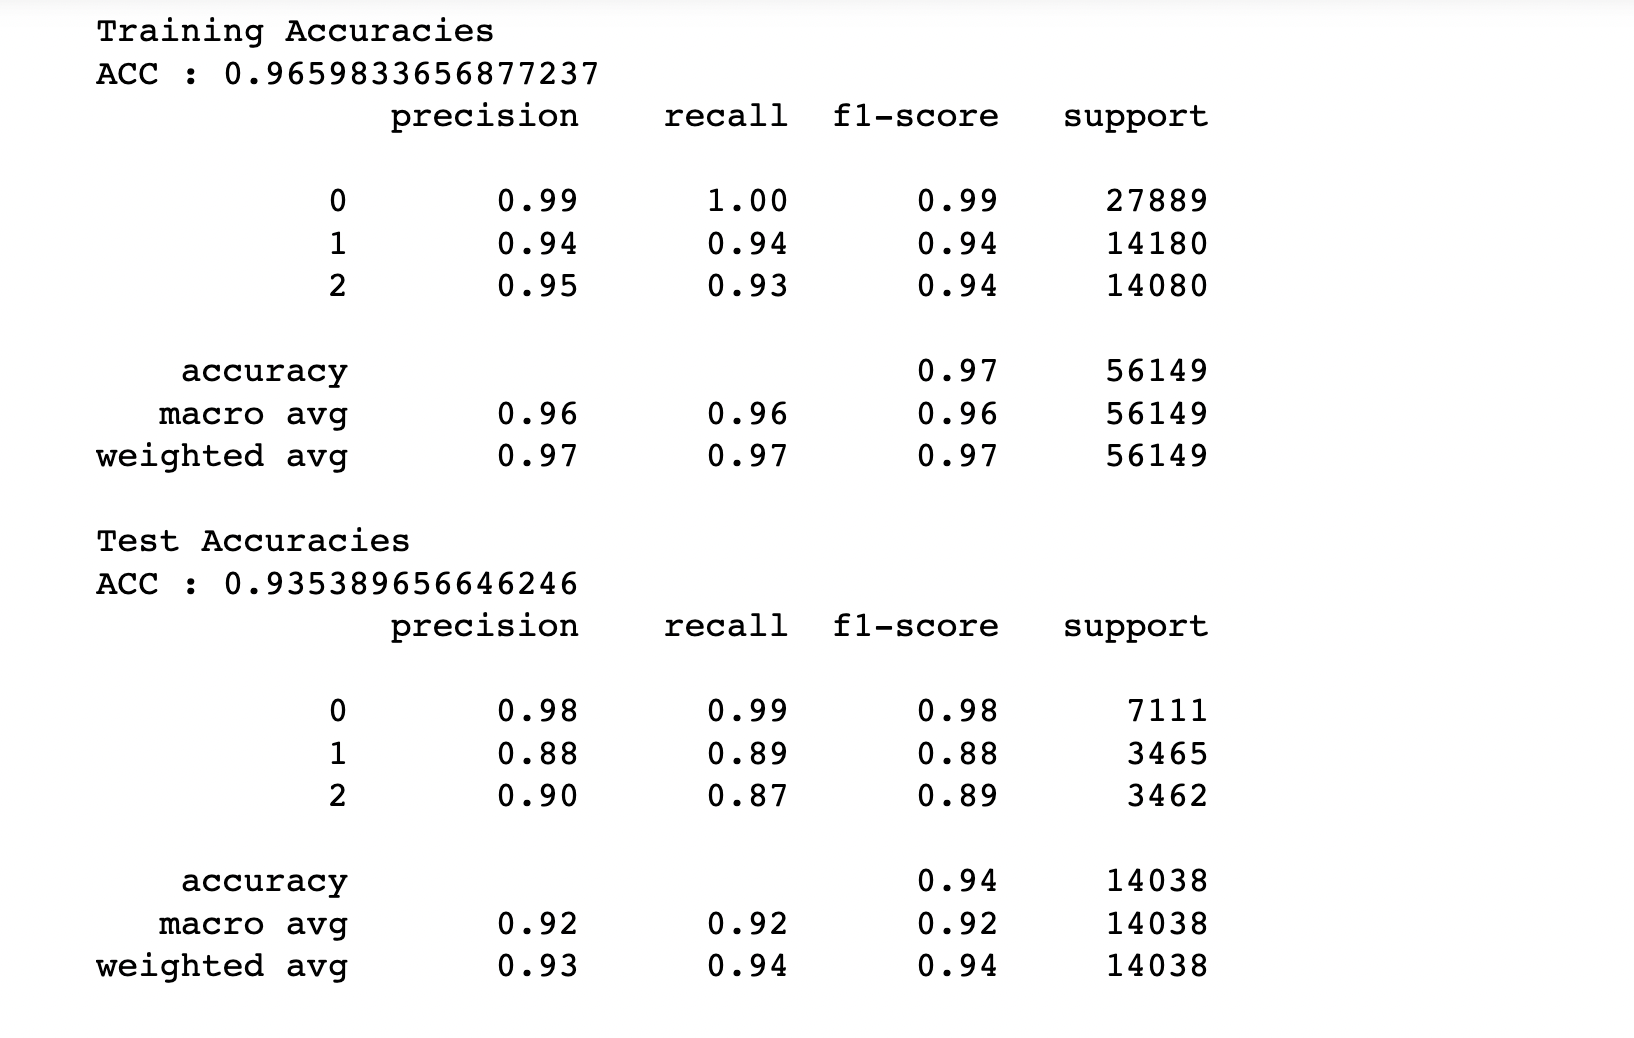

In [ ]:
predictions['id'] = test_df['id']
predictions.to_csv("submission.csv", index=False)

In [543]:
clf_report_lr_test.to_csv("submission.csv", index=False)


AttributeError: 'str' object has no attribute 'to_csv'

In [ ]:
X_train,X_dev,y_train,y_dev = train_test_split(X,y,test_size=0.3,random_state=50)

In [ ]:
# Saving a finalised model as pickle file 

# save the model to disk
filename = 'pickle/finalized_model.pkl'
pickle.dump(clf, open(filename, 'wb'))


# ** The End **